# Rossman Store Sales Prediction

# Steps: 
1. Explatory Data Analysis
2. Time Series Analysis 
    2.1. Predictive Modeling 
3. Results

![](https://m.strelapark.de/fileadmin/_processed_/csm_rossmann_shop_foto_stralsund_1633a5fb67.jpg)

## Used dataset is **rossmann store data**. It operates over 3,000 drug stores in 7 European countries. The challenge is to predict their daily sales for up to six weeks in advance.

In [87]:
# pip install --upgrade pip'

In [88]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
# from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [89]:
# Import datast 
# store = pd.read_csv('../data/store.csv')
# train = pd.read_csv('../data/train.csv', index_col='Date', parse_dates=True)
# test = pd.read_csv('../data/test.csv')

store = pd.read_csv('../data/preprocessed_store.csv')
train = pd.read_csv('../data/preprocessed_train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv('../data/preprocessed_test.csv')
train.shape, test.shape, store.shape

((1017209, 8), (41088, 8), (1115, 10))

In [90]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [91]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [92]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


# **1. Explamatory Data Analysis(EDA)**

### 1.1: Trends & Seasonility 
How the sales vary with month, promo(First promotional Offer), promo2(Second Promotional Offer) and years. 

In [93]:
train.shape

(1017209, 8)

Train data as almost 1M observations of sales data over the year of appriximatelly (2013-2015). 
Okay, bread Date column in Year, Month, Day, Week columns

In [94]:
# Extract Year, Month, Day, Week columns
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekofYear'] = train.index.isocalendar().week

train['SalesPerCustomer'] = train['Sales'] / train['Customers']


In [95]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [96]:
# Checking the data when the store is closed 
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

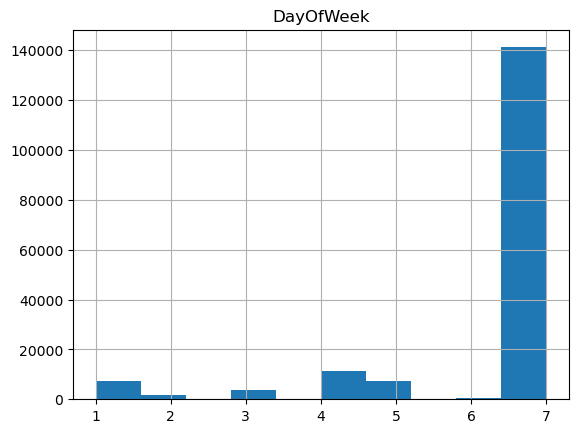

In [97]:
# Check when the store was closed 
train_store_closed.hist('DayOfWeek')

From this chart, we could see that, 7th day store was mostly clodes. It is Sunday and makes sense. 

<Axes: xlabel='SchoolHoliday'>

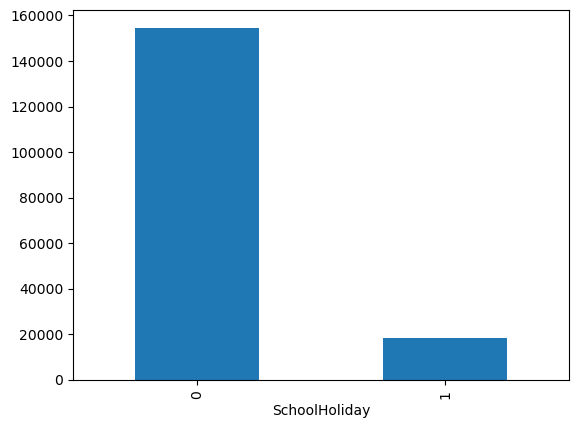

In [98]:
# Check whether there school was closed for holyday 
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar')

<Axes: xlabel='StateHoliday'>

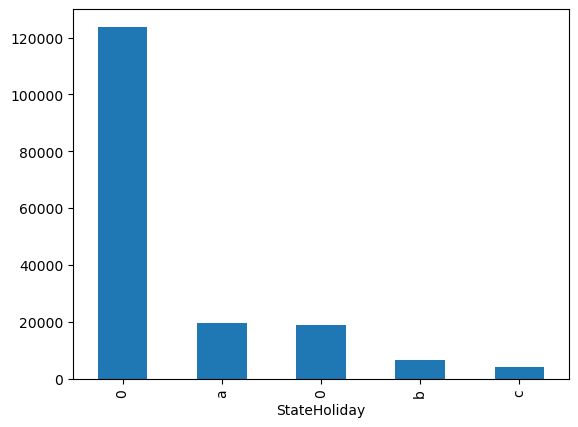

In [99]:
# Check whether there school was closed for holyday 
train_store_closed['StateHoliday'].value_counts().plot(kind='bar')

In [100]:
# Number of days with closed stores
train[(train.Open == 0)].shape[0]

172817

In [101]:
# Okay now check No. of dayes store open but sales zero ( It might be caused by external refurbishmnent)
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [102]:
# Work with store data 
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [103]:
# Work with test data 
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [104]:
# Join train and store table 
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [105]:
train_store_joined.groupby('StoreType')[['Customers', 'Sales', 'SalesPerCustomer']].sum().sort_values('Sales', ascending=False)


,Customers,Sales,SalesPerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


In [106]:
# Closed and zero-sales observations 
train_store_joined[(train_store_joined.Open == 0) | (train_store_joined.Sales==0)].shape

(172871, 22)

So, we have 172,871 observations when the stores were closed or have zero sales.

In [107]:
# Open & Sales >0 stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]
train_store_joined_open

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,1,6905,471,1,1,0,1,2013,1,...,14.660297,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017204,1115,6,4771,339,1,0,0,1,2013,1,...,14.073746,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,4540,326,1,0,0,1,2013,1,...,13.926380,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,4297,300,1,0,0,1,2013,1,...,14.323333,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


# Correlation Analysis

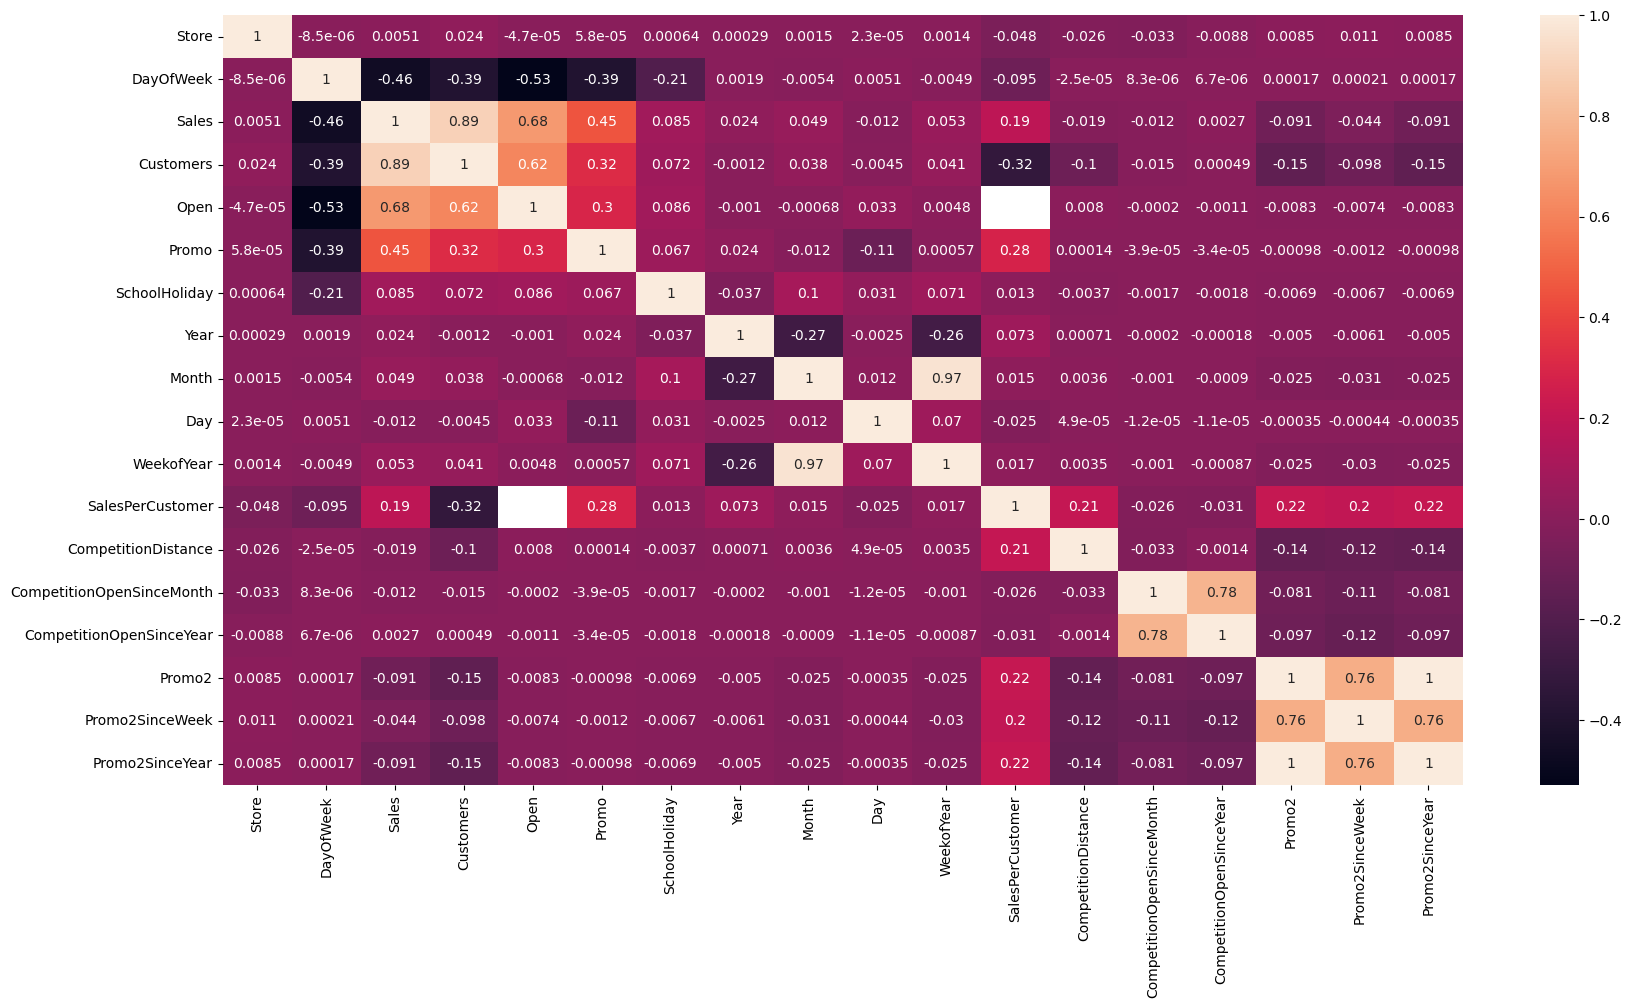

In [108]:
plt.figure(figsize=(20, 10))
sns.heatmap(train_store_joined.select_dtypes(include=[np.number]).corr(), annot=True)
plt.show()


#### From the above chart we can see a strong positive correlation between the amount of Sales and Customers visiting the store. We can also observe a positive correlation between a running promotion (Promo = 1) and number of customers.

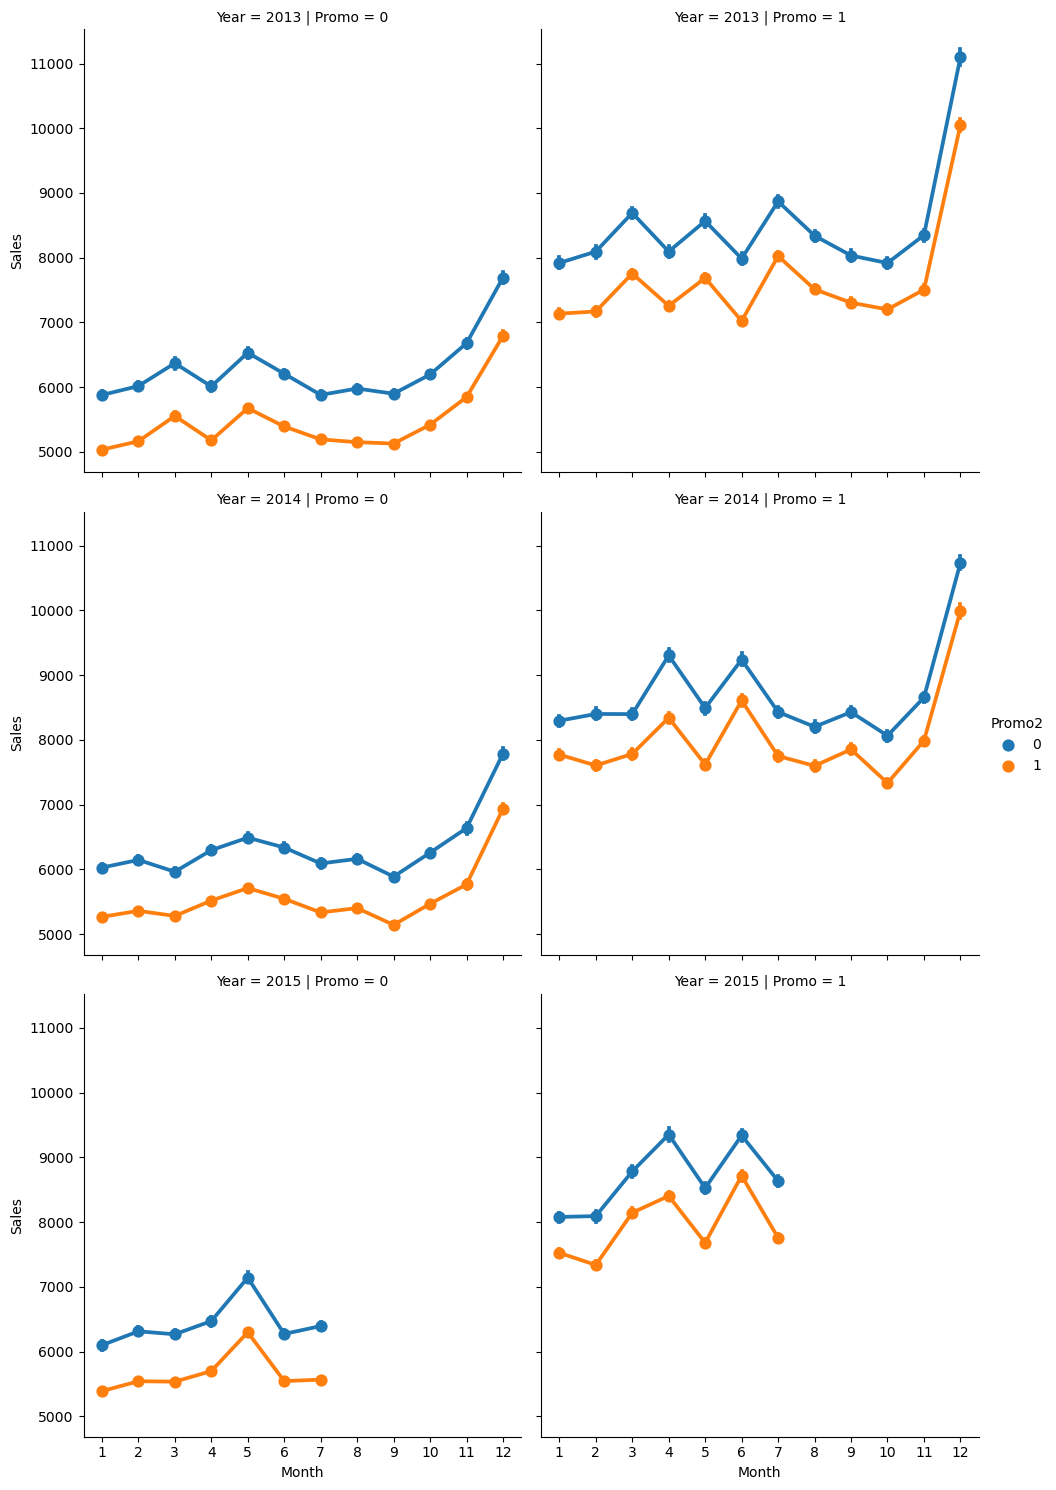

In [109]:
sns.catplot(data=train_store_joined_open, x='Month', y='Sales',
            col='Promo', hue='Promo2', row='Year', kind='point')


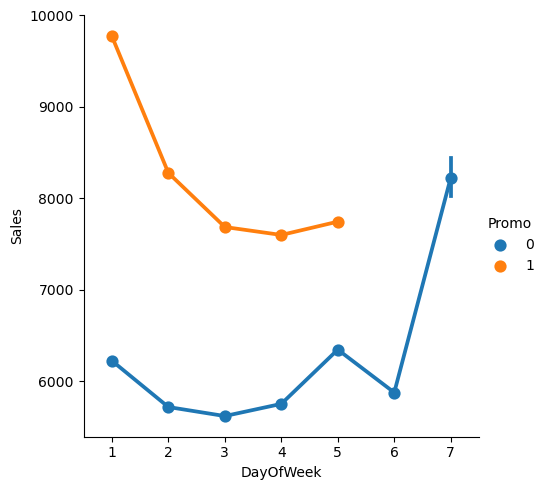

In [110]:
sns.catplot(data=train_store_joined_open, x='DayOfWeek', y='Sales',
            hue='Promo', kind='point')


### From the above chart, 0 represents sales and 1 represents promotin in a week. Promotions are not given in weekend (Saturday and Sunday). Because peoples are goinf to buy their household things on the weekend and wothout promotion sales increased in a dramatic way. Promotion are highest on monday and as well as sales are high on that day. 

# **Insights**
### 1. Storetype a has highest customer and sales 
### 2. Storetype b has highest SalesPerCustomer 
### 3. There is no promotion offer in Saturday and Sunday
### 4. Customers are going to buy their goods in tuesday on promotional offer. 

# 2. Time Series Analysis 

In this section we will consider only one store from each store type(a, b, c, d). 

In [111]:
pd.plotting.register_matplotlib_converters()

Register pandas formatters and converters with matplotlib.

This function modifies the global matplotlib.units.registry dictionary. pandas adds custom converters for

pd.Timestamp

pd.Period

np.datetime64

datetime.datetime

datetime.date

datetime.time

In [112]:
# Data Preparation: input should be float type 

# our Sales data is int type so lets make it float
train['Sales'] = train['Sales'] * 1.00

train['Sales'].head()

Date
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: Sales, dtype: float64

In [113]:
train.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

<Axes: xlabel='Date'>

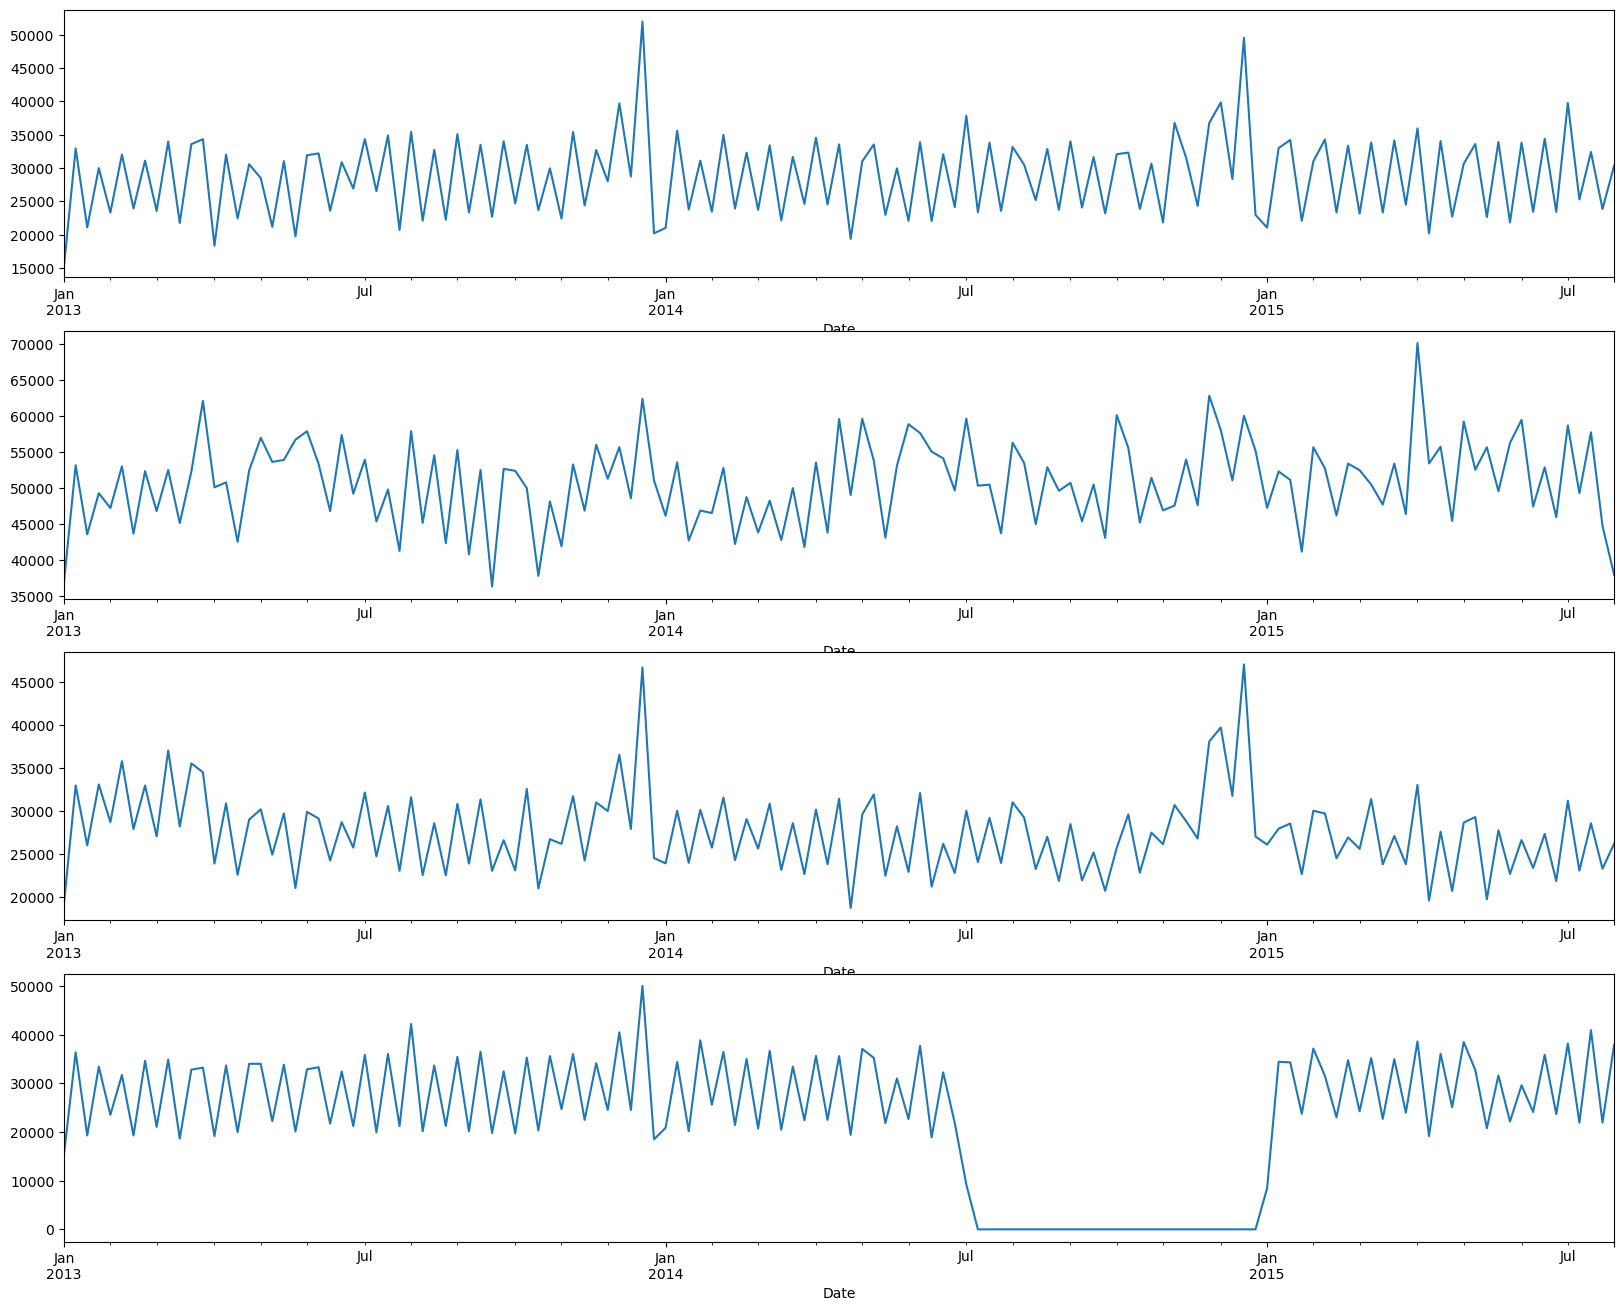

In [114]:
# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 16))

# Visualize Trend 
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)


# will be used to resample the speed column of our DataFrame
#The 'W' indicates we want to resample by week. At the bottom of this post is a summary of different time frames.
# You could use for Day = d, MOnth = m, Year = y

From the above chart we could see sales of store type A, C has highest sales at the end of the year. December months has christmas season. So, that they get highes salary. At the end of the month their sell decrease. We can not find semiler trend for store B and D, it could be there is no
data for that time perion. Possible reason is "store closed".

# stationarity of Time Seriese

Stationarity means that the statistical properties of a time series do not change over time. Some stationary data is (constant mean, constant variance and constant covariance with time). 

### There are 2 ways to test the stationarity of time series
* A) Rolling Mean: Visualization 
* B) Dicky - Fuller test: Statistical test

**A) Rolling Mean:** A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slid across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.

**B) Dicky -Fuller test:** This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [115]:
# lets create a functions to test the stationarity 
def test_stationarity(timeseries):
    # Determine rolling statestics 
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    # plotting rolling statestics 
    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
    plt.legend(loc='best')
    plt.show()
    
    # Performing Dickey-Fuller test 
    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')
    
    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)
    

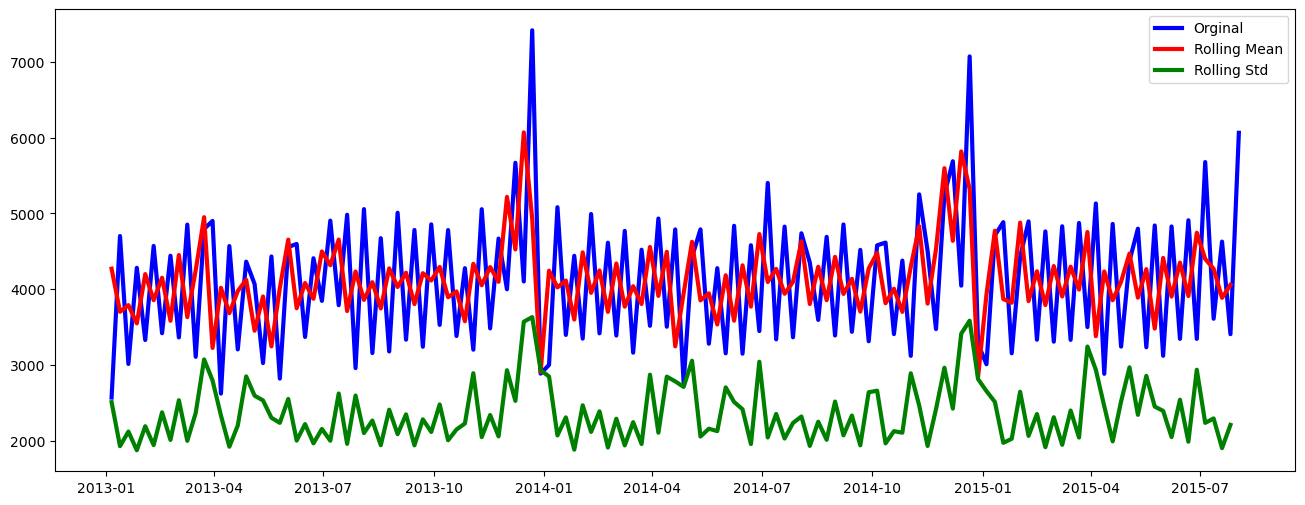

Result of Dickey-Fuller test:
ADF Statestics: -6.218237
P-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [116]:
test_stationarity(sales_a)

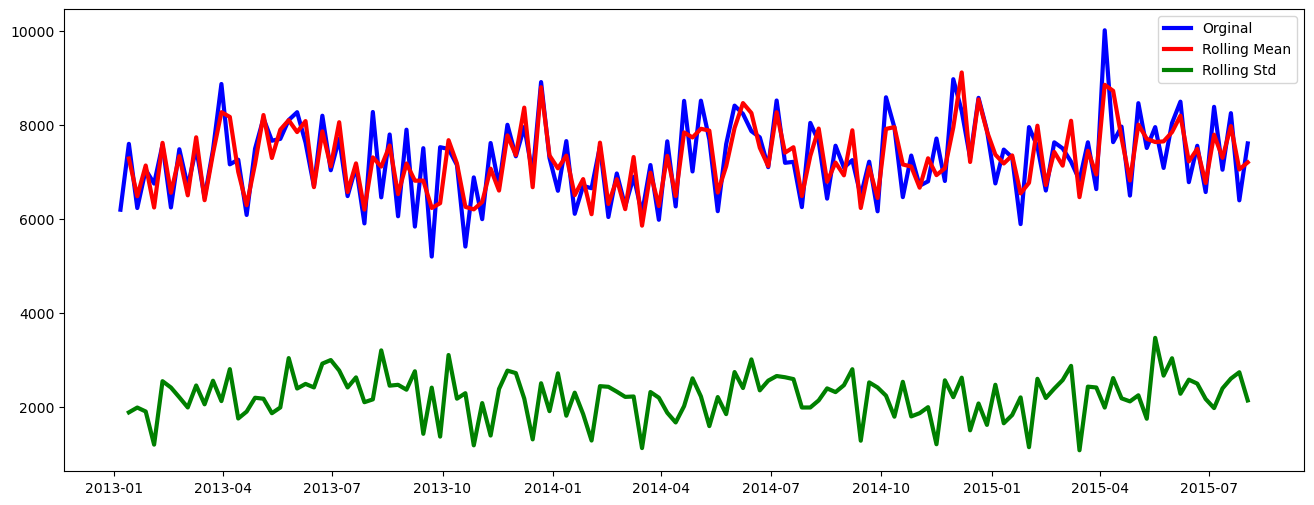

Result of Dickey-Fuller test:
ADF Statestics: -5.660918
P-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [117]:
test_stationarity(sales_b)

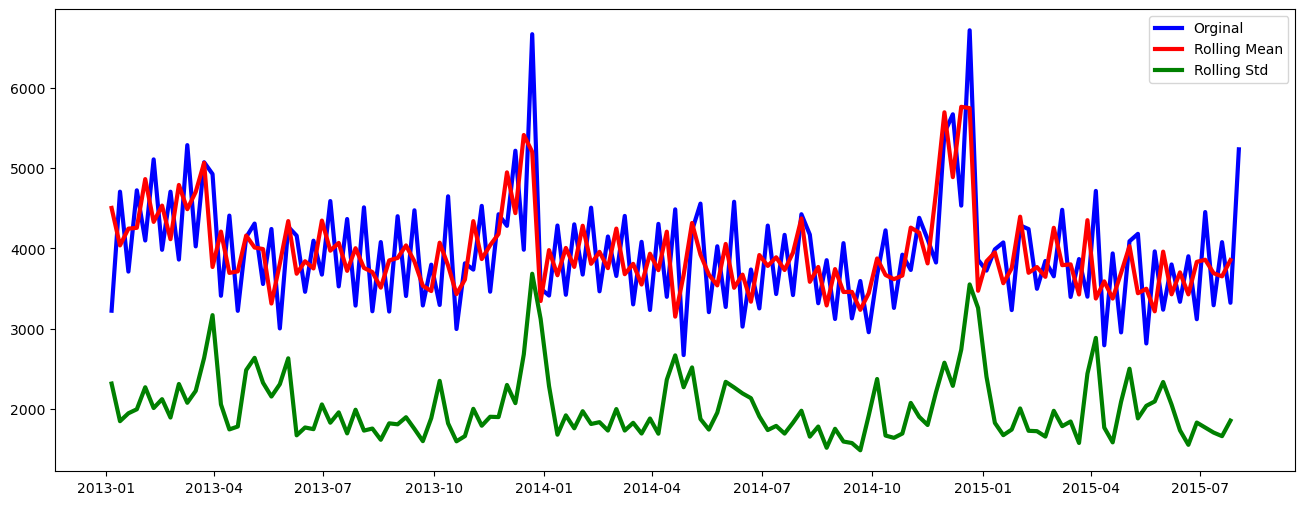

Result of Dickey-Fuller test:
ADF Statestics: -4.374784
P-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [118]:
test_stationarity(sales_c)

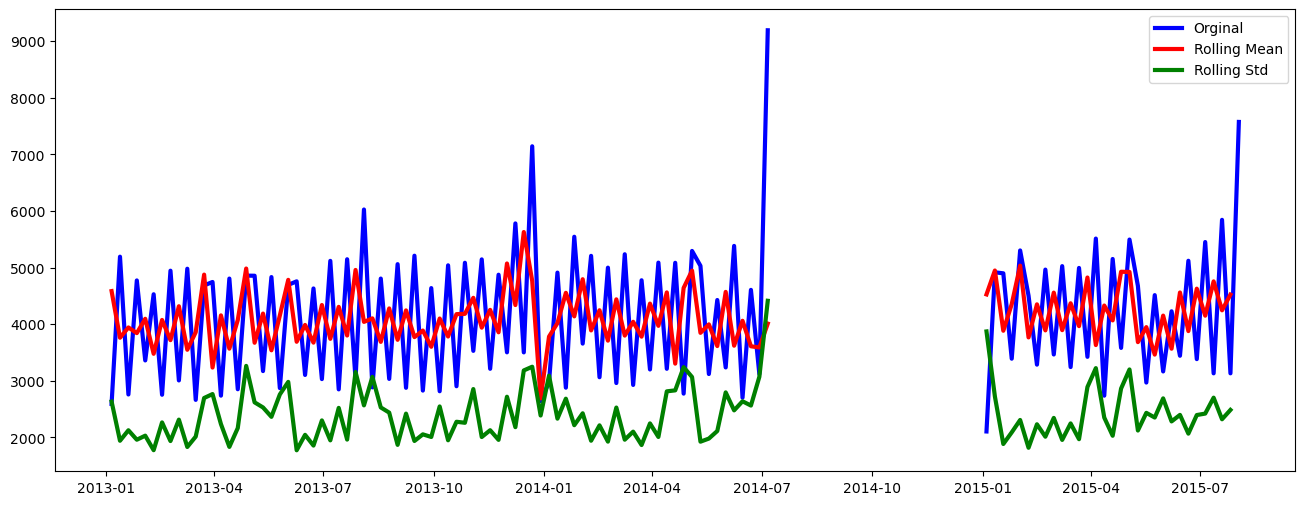

Result of Dickey-Fuller test:
ADF Statestics: -6.237461
P-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [119]:
test_stationarity(sales_d)

# Lets create trends and seasonality 

In [120]:
# plotting trends and seasonality 

def plot_timeseries(sales, StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(20)

    decomposition = seasonal_decompose(sales, model='additive', period=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')

    plt.title(f'Decomposition Plots for Store Type {StoreType}')

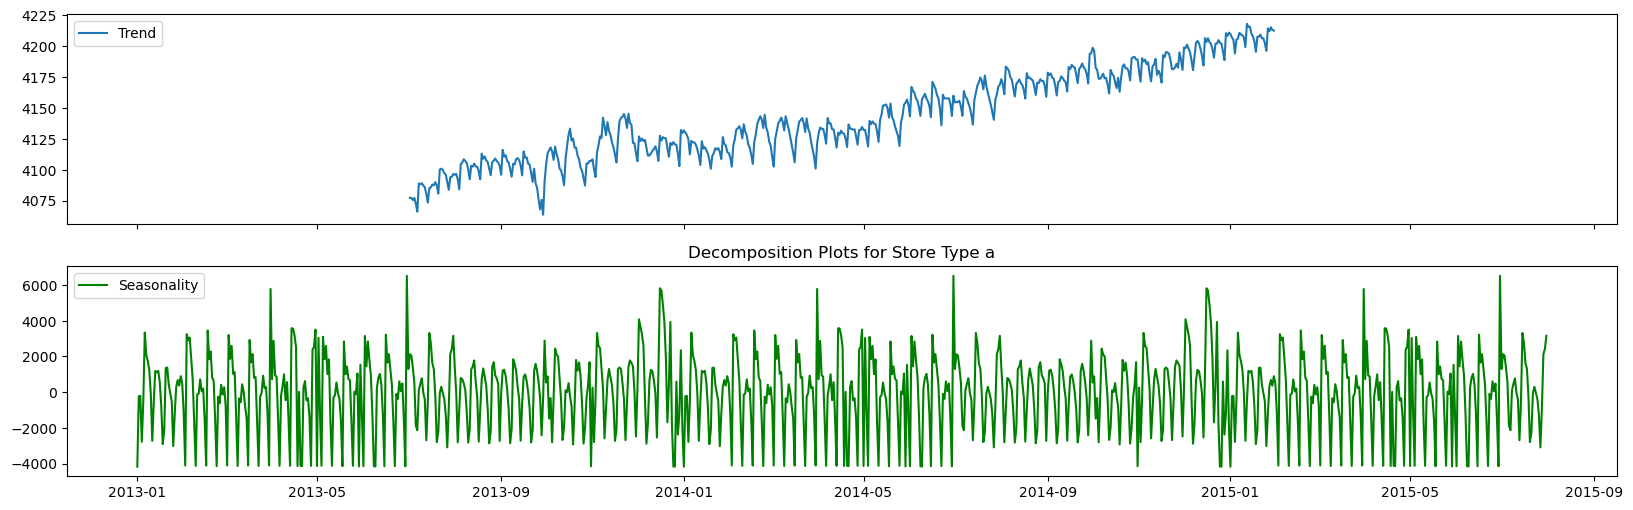

In [121]:
plot_timeseries(sales_a, 'a')

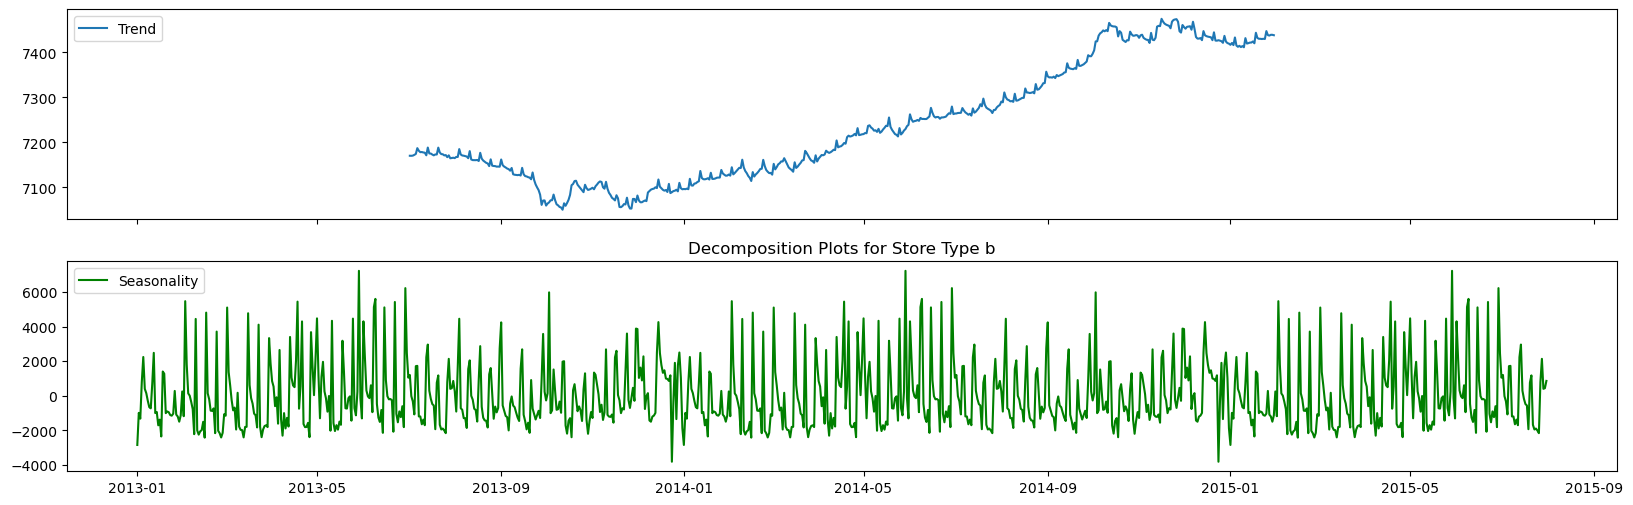

In [122]:
plot_timeseries(sales_b, 'b')

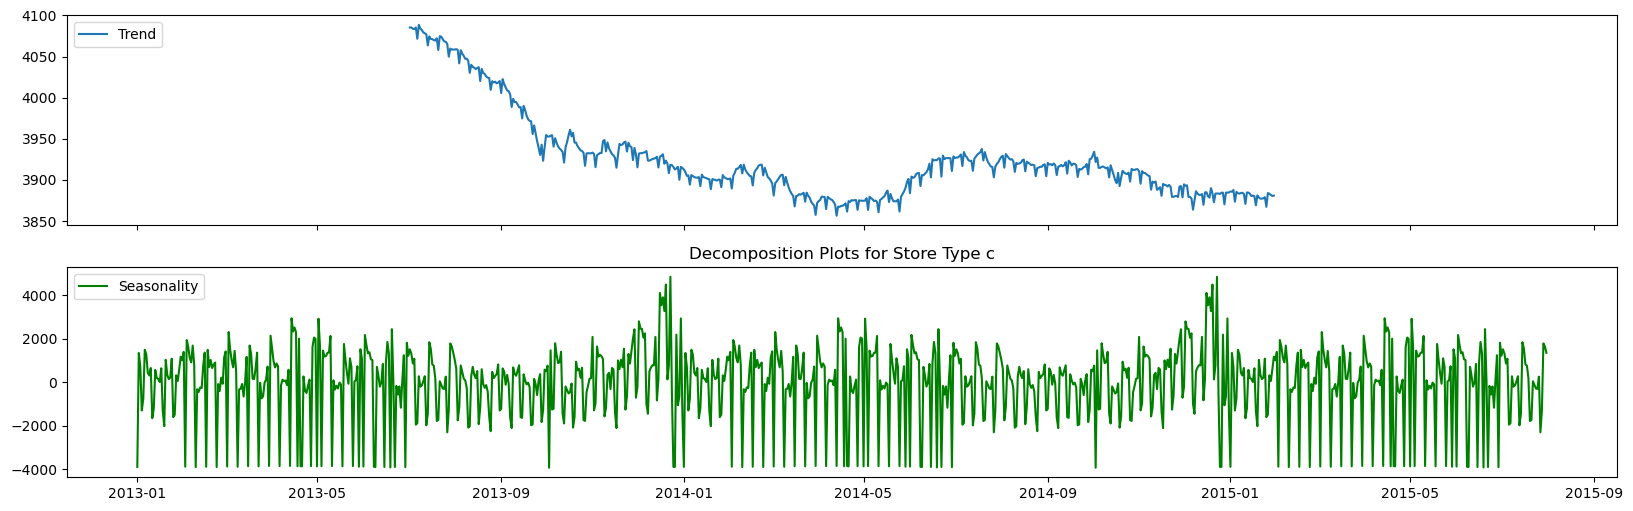

In [123]:
plot_timeseries(sales_c, 'c')

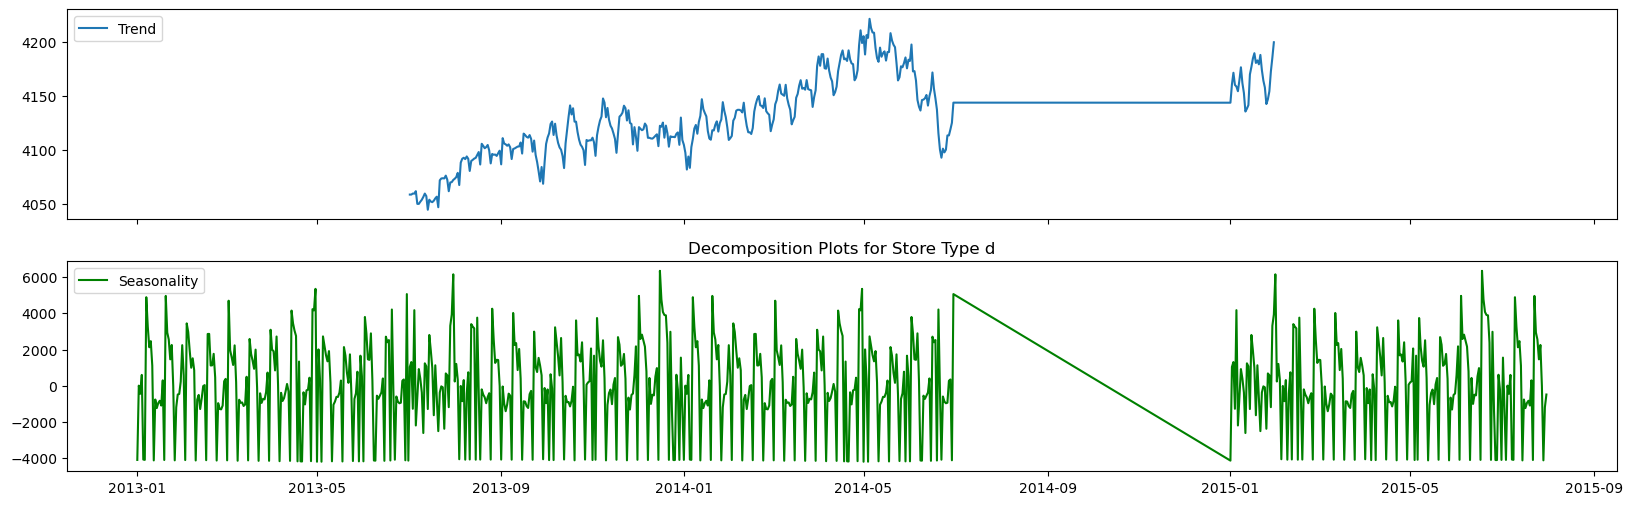

In [124]:
plot_timeseries(sales_d, 'd')


From the above plots, we can see that there is seasonality and trend present in our data. So, we'll use forecasting models that take both of these factors into consideration. For example, SARIMAX and Prophet.

# Time Series Forcusting 

## Evaluation Matrics

**1. MAE - Mean Absolute Error:** It is the average of the absolute difference between the predicted values and observed values.
![](https://www.statisticshowto.com/wp-content/uploads/2016/10/MAE.png)

**2. RMSE - Root Mean Square Error:** It is the square root of the average of squared differences between the predicted values and observed values.
![](https://help.innovyze.com/download/attachments/2459040/scadawatch_analytical_function_rmse_formula.png?version=1&modificationDate=1555033531000&api=v2)

# Model 01: Seasonal Autoregressive Integrated Moving Average
In order to use this model, we need to first find out values of **p, d and q. p** represents number of Autoregressive terms - lags of dependent variable.
* q represents number of Moving Average terms
* lagged forecast errors in prediction equation. 
* d represents number of non-seasonal differences.

**To find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots.**

**ACF** measure of correlation between time series with a lagged version of itself. 
**PACF** measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

**p value** is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.

**q value** is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.


### Autocorrelation function to make ACF and PACF

In [125]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('PACF')


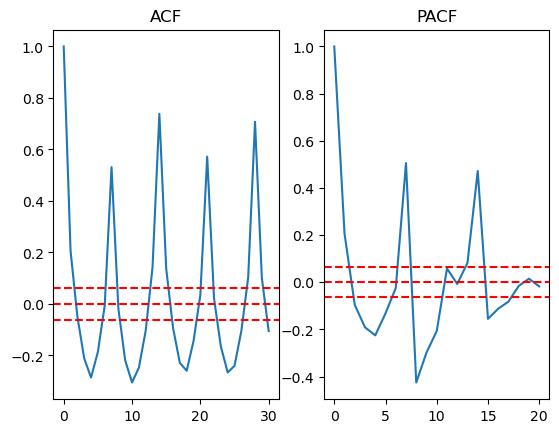

In [126]:
# ACF and PCF for store A
auto_corr(sales_a)

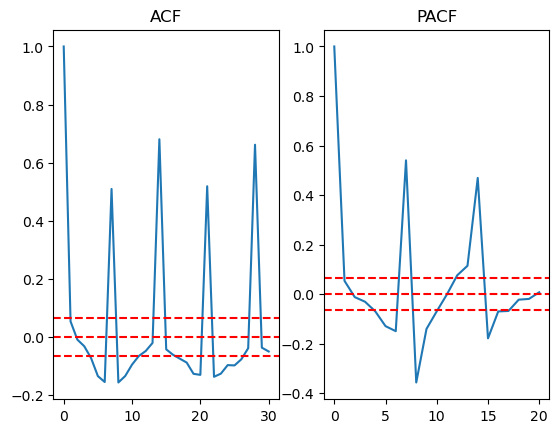

In [127]:
# ACF and PCF for store B
auto_corr(sales_b)

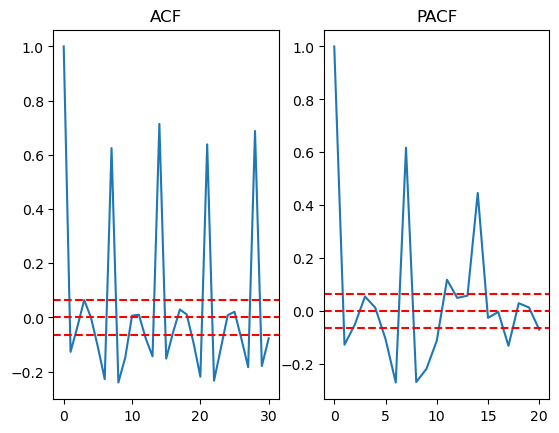

In [128]:
# ACF and PCF for store C
auto_corr(sales_c)

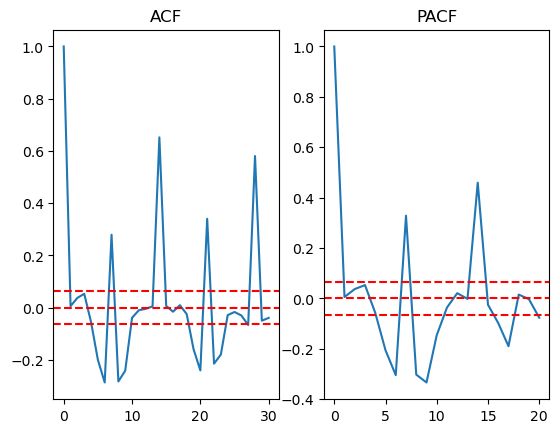

In [129]:
# ACF and PCF for store D
auto_corr(sales_d)

The above graphs suggest that the p = 2 and q = 2 but let's do a grid search and see which combination of p, q and d gives the lowest Akaike information criterion (**AIC**, which tells us the quality of statistical models for a given set of data. Best model uses the lowest number of features to fit the data.

If we are to predict the sales of each store, we need to consider the whole data set rather than one store of each category. We took one store of each category to understand the tiem series data but from now on, we'll use the whole dataset for modelling

In [130]:
train['Sales'] = pd.to_numeric(train['Sales'], errors='coerce')
train.dropna(subset=['Sales'], inplace=True)

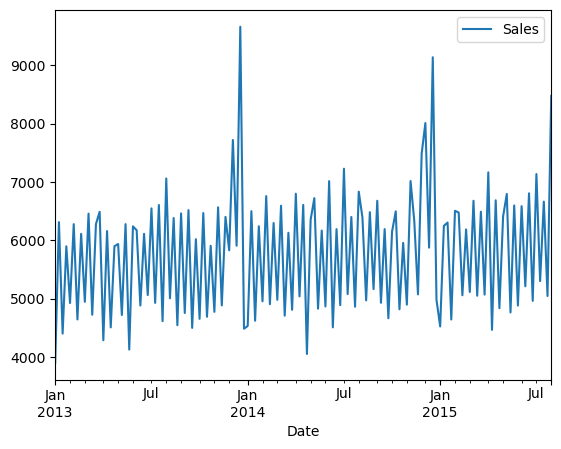

In [131]:
# Summering sales on per week basis 
# ARIMA = Autoregresive Integrated Moving Average 

train_arima = train[['Sales']].resample('w').mean()

train_arima.plot()
plt.show()


In [132]:
train_arima.head()

,Sales
Date,
2013-01-06,3906.314098
2013-01-13,6313.289174
2013-01-20,4404.582319
2013-01-27,5898.804484
2013-02-03,4928.382960


### Hyperparamter turing ARIMA model
As discussed above, we have three parameters (p, d and q) for SARIMA model. So, in order to choose the best combination of these parameter, we'll use a grid search. The best combination of parameters will give the lowest AIC score.

In [133]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


let's iterate through these combinations to see which one gives the lowest AIC score.

In [134]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807690444
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207667
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522798385
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.7057912673195
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107311388
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943416113
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305009787
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135683
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259670982
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617136049
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.9085895013973
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089751813
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842532256
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.580453192

So, we can see that, the above grid search result our optimal paramiter (ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1807.3489408440882) 

### Fitting the model

In [135]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_sarima= model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5543      0.098     -5.652      0.000      -0.747      -0.362
ma.L1         -1.1418      0.055    -20.766      0.000      -1.250      -1.034
ar.S.L12      -0.1554      0.110     -1.417      0.156      -0.370       0.060
ma.S.L12      -1.0093      0.700     -1.441      0.150      -2.382       0.364
sigma2      6.236e+05   4.65e+05      1.342      0.180   -2.87e+05    1.53e+06


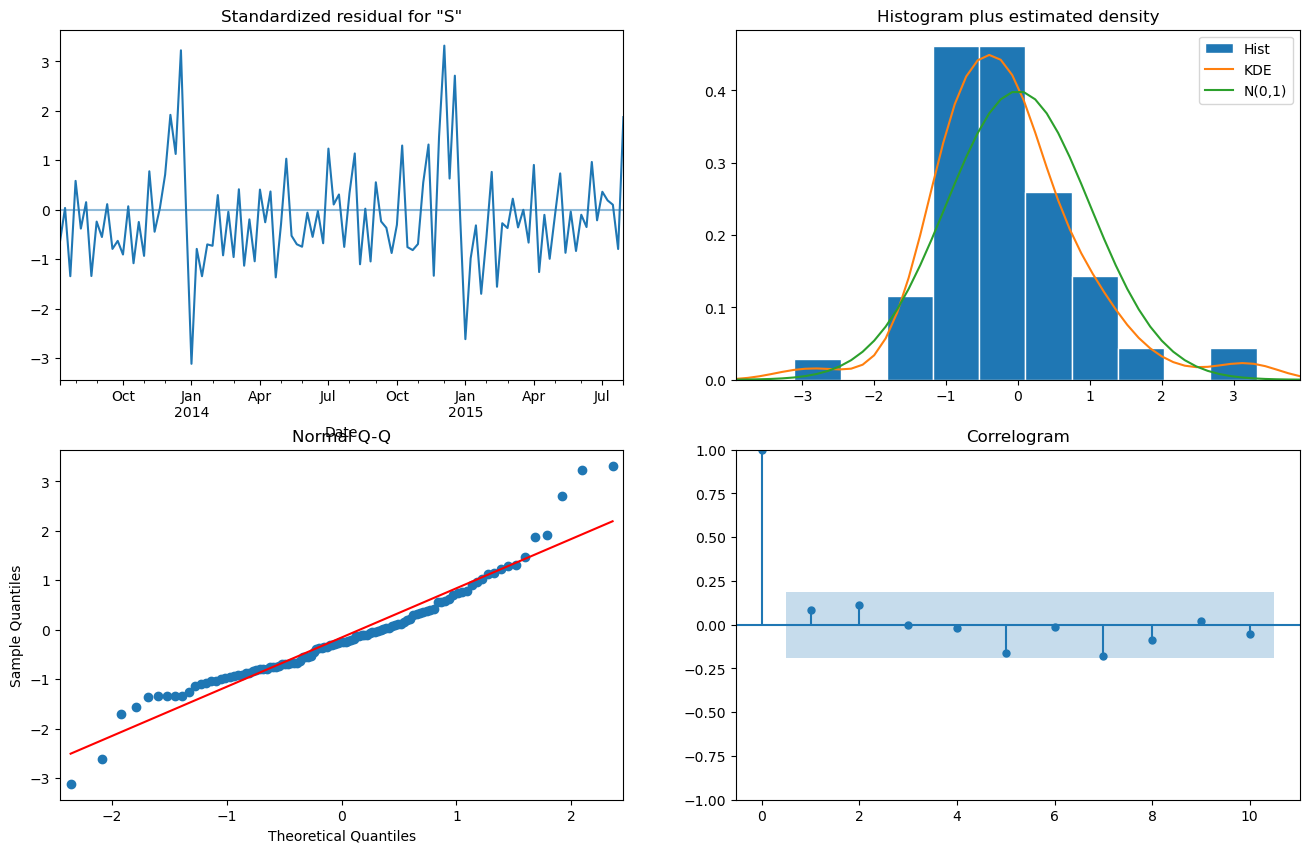

In [136]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.show()

We can see from the above 'Histogram plus estimated density' plot that our KDE (Kernel Desnity Estimator) plot closely follows the N(0,1) normal distribution plot. The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

**Standardized residual plot tells us that there is no major seasonality trend, which is confirmed by Correlogram (autocorrelation) plot. Autocorrelation plot tells us that the time series residuals have low correlation with lagged versions of itself**

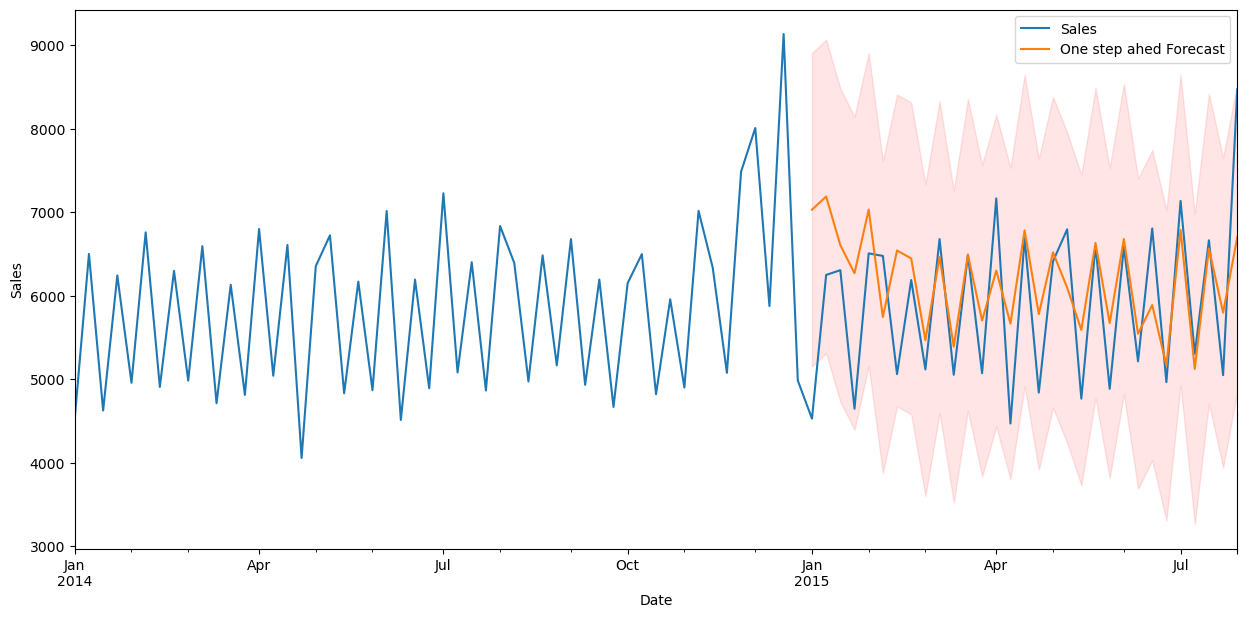

Root Mean Squared Error =  867.9550505622559


In [137]:
# Model prediction 

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

# Get confidence interval of forecast 
pred_ci = pred.conf_int()

ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

rms_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
print('Root Mean Squared Error = ',rms_arima)

In [138]:
# Save your predicted results for future validation. 
# You could find this results in output sections

train_arima_forecasted.to_csv('predicted_data.csv')
print('Predicted Data Saved in output')

Predicted Data Saved in output


# Model 2: Prophetic 
From our Grid search and foundoptimal parameter we also have another loweset AIC: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.29. Lets try to use it 

In [139]:
# Creating a train dataset
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [140]:
# Converting col names to specific names as required by Prophet library
train_prophet = train_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
train_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
0,2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
1,2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400
2,2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675
3,2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457
4,2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118


In [141]:
# Downsampling to week because modelling on daily basis takes a lot of time
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])

ts_week_prophet = train_prophet.set_index("ds").select_dtypes(include=[np.number]).resample("W").sum()

ts_week_prophet.head()

,Store,DayOfWeek,y,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
ds,,,,,,,,,,,,
2013-01-06,3732032,30103,26129335.0,3110602,4471,0,4533,13464957,6689,23414,6689,39406.143319
2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,560,15711465,7805,78050,15610,65076.326540
2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0,15711465,7805,132685,23415,57208.229656
2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0,15711465,7805,187320,31220,65073.831993
2013-02-03,4355190,31220,38466029.0,4507650,6667,0,128,15711465,11150,138260,39025,59686.174407


In [142]:
train_store_joined.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekofYear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

# MOdel 2: XGBoost
Now we will drop columns that are correlated (e.g Customers, SalePerCustomer) in addition to merging similar columns into one column (CompetitionOpenSinceMonth, CompetitionOpenSinceYear).

In [143]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalesPerCustomer', 'PromoInterval'], axis=1)

In [144]:
ts_xgboost.head()
# Here we do not have any categorical variables so we do not have to convert them into numerical to use in XGBoost 

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,5263,1,1,0,1,2015,7,31,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
1,1,4,5020,1,1,0,1,2015,7,30,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
2,1,3,4782,1,1,0,1,2015,7,29,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
3,1,2,5011,1,1,0,1,2015,7,28,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
4,1,1,6102,1,1,0,1,2015,7,27,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0


In [145]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekofYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [146]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [147]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20) 

# Baseline XGBoost 

In [148]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[0]	train-rmse:3214.24690	eval-rmse:3220.16037
[1]	train-rmse:2845.53328	eval-rmse:2850.87115
[2]	train-rmse:2637.27966	eval-rmse:2642.42168
[3]	train-rmse:2518.21853	eval-rmse:2520.83824
[4]	train-rmse:2451.41165	eval-rmse:2453.17446
[5]	train-rmse:2411.68367	eval-rmse:2413.00506
[6]	train-rmse:2383.82671	eval-rmse:2384.61983
[7]	train-rmse:2342.66072	eval-rmse:2343.09507
[8]	train-rmse:2329.24620	eval-rmse:2329.82653
[9]	train-rmse:2276.17927	eval-rmse:2277.65817
[10]	train-rmse:2262.22309	eval-rmse:2264.15773
[11]	train-rmse:2241.08718	eval-rmse:2243.41211
[12]	train-rmse:2233.49119	eval-rmse:2235.77781
[13]	train-rmse:2220.86504	eval-rmse:2223.36590
[14]	train-rmse:2174.19377	eval-rmse:2176.14032
[15]	train-rmse:2164.94922	eval-rmse:2166.91840
[16]	train-rmse:2127.53307	eval-rmse:2130.55754
[17]	train-rmse:2080.93979	eval-rmse:2083.96958
[18]	train-rmse:2037.99324	eval-rmse:2040.79345
[19]	train-rmse:2030.65685	eval-rmse:2033.04615
[20]	train-rmse:2023.65275	eval-rmse:2026.25089
[2

In [149]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1241.040119582694


# Hypertuning XGBoost
Now let's try to decrease the RMSE of XGBoost by passing different values for our hyperparameters in the XGBoost model.

**eta:** It defines the learning rate i.e step size to learn the data in the gradient descent modeling (the basis for XGBoost). The default value is 0.3 but we want to keep the learning rate low to avoid overfitting. So, we'll choose **0.2** as eta

**max_depth:** Maximum depth of a tree. The default value is 6 but we want our model to be more complex and find good predictions. So, let's choose 10 as max depth.

**gamma:** Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. The default value is 0, let's choose a little higher value so as to get good predictions

In [150]:
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:3602.99735	eval-rmse:3609.96009
[1]	train-rmse:3388.55429	eval-rmse:3395.96442
[2]	train-rmse:3198.98306	eval-rmse:3207.58287
[3]	train-rmse:3038.08601	eval-rmse:3046.51892
[4]	train-rmse:2893.78184	eval-rmse:2903.75070
[5]	train-rmse:2772.66971	eval-rmse:2782.42330
[6]	train-rmse:2666.04983	eval-rmse:2676.40809
[7]	train-rmse:2568.62075	eval-rmse:2579.72834
[8]	train-rmse:2493.66549	eval-rmse:2505.45578
[9]	train-rmse:2427.00911	eval-rmse:2439.24141
[10]	train-rmse:2369.79703	eval-rmse:2382.14884
[11]	train-rmse:2325.96651	eval-rmse:2338.86738
[12]	train-rmse:2279.83013	eval-rmse:2292.83598
[13]	train-rmse:2243.75962	eval-rmse:2257.59396
[14]	train-rmse:2215.51900	eval-rmse:2230.14549
[15]	train-rmse:2186.41228	eval-rmse:2201.35391
[16]	train-rmse:2158.21660	eval-rmse:2173.84514
[17]	train-rmse:2134.08014	eval-rmse:2150.60644
[18]	train-rmse:2118.98491	eval-rmse:2136.09466
[19]	train-rmse:2099.55240	eval-rmse:2117.46077
[20]	train-rmse:2083.87364	eval-rmse:2102.01828
[2

In [151]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 1118.508412273212


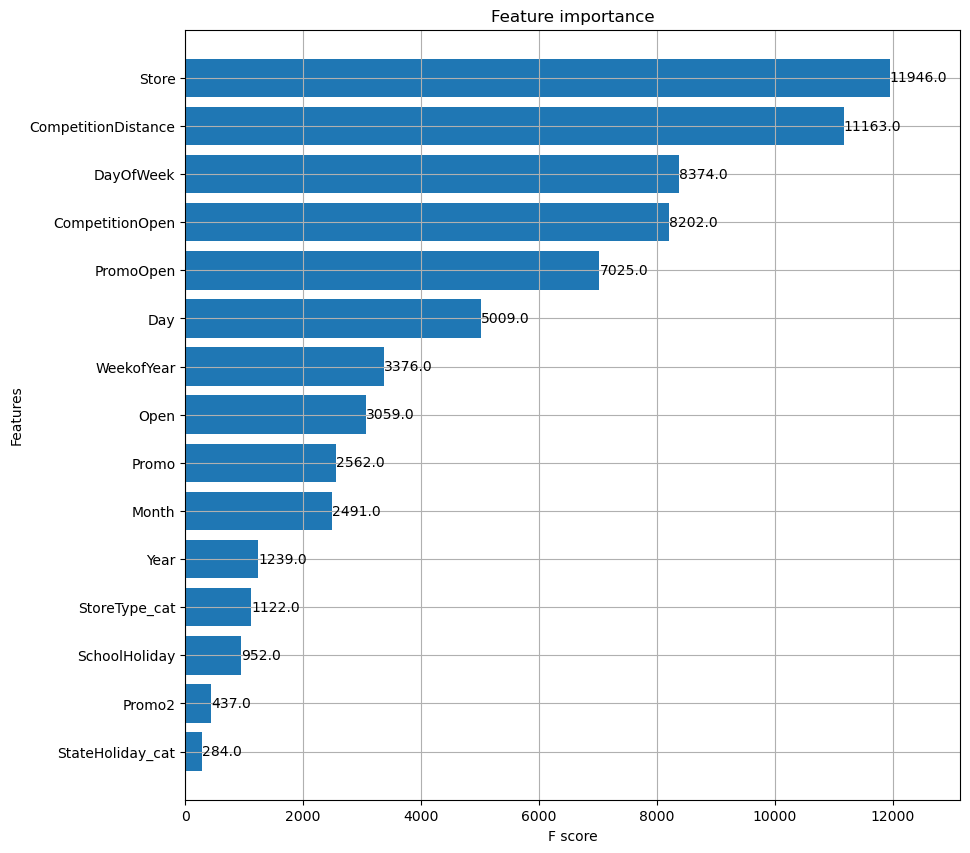

In [152]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Final XGBoost Model:
After hypertuning, we were able to reduce RMSE from 1223.31 to 1176.20 which is great! Now, let's compare the performance of all models

# Results

In [153]:
# Comparing performance of above three models - through RMSE
rms_arima = format(float(rms_arima))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
    "Model": ["SARIMA",  "XGBoost"],
    "RMSE": [rms_arima, rms_xgboost_2]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
1,XGBoost,1118.508412273212
0,SARIMA,867.9550505622559


# Model Comparison & Selection
We used the Root Mean Squared Error **(RMSE)** to evaluate and validate the performance of various models used. Let's see which model performed better and why/why not.

a) We can see from the above table that **SARIMA** performs the best than **XGBoost**.

b) It makes sense because **SARIMA is designed specifically for seasonal time series data while XGBoost is a general (though powerful) machine learning approach with various applications.**


Based on the above analysis, we'll choose ARIMA as our final model to predict the sales because it gives us the least RMSE and is well suited to our needs of predicting time series seasonal data.